# SpeechSlice Demonstration

This notebook contains the code flow for gathering speech signals, performing several short-time analyses, and then grouping the short segments together based on some short-time features. Along the way, several quantitative metrics are extracted, and many plots are presented to aid in visualization.

In [126]:
#################################################################
# Please run the following cell to import all necessary modules #
#################################################################
import librosa
import numpy as np
import sounddevice as sd
import scipy
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.signal import lfilter
from scipy.integrate import simpson
from scipy.stats import chi2
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dtw import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import allosaurus

from segmentation import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Defining commonly used parameters
audio_path_global = "demo_audio\SA1.WAV.wav"
samples_global, sample_rate_global = librosa.load(audio_path_global)

<>:2: SyntaxWarning:

invalid escape sequence '\S'

<>:2: SyntaxWarning:

invalid escape sequence '\S'

C:\Users\tabba\AppData\Local\Temp\ipykernel_604\3062909283.py:2: SyntaxWarning:

invalid escape sequence '\S'



# Short-time Quantitative Metrics

### Normalizing and Plotting Speech Signal with TIMIT Dataset Segmentation

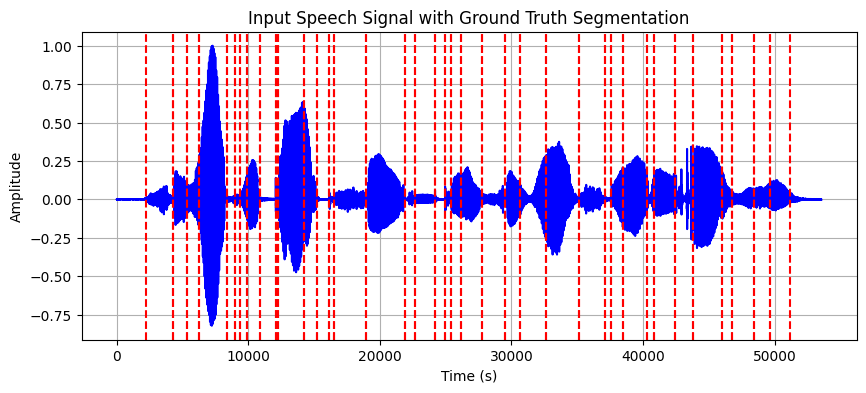

In [29]:
from scipy.io import wavfile

# compare with ground truth by examining the .phn file 
def compare_ground_truth(wav_file, phn_file):
    boundaries = [] 
    with open(phn_file, "r") as file:
        # Iterate through each line in the file
        for line in file:
            parts = line.split()
            # Append the extracted numbers to the list
            boundaries.append(int(parts[0]))
            boundaries.append(int(parts[1]))
        samples = boundaries[-1]
        boundaries = boundaries[2:]
        boundaries = boundaries[:-2]
    return boundaries

def normalize_and_plot(audio_file_path, ground_truth_file_path):

    # take input 
    sample_rate, audio_data = wavfile.read(audio_file_path)
    
    # normalize by using the maximum 
    # rms normalization has the risk of clipping, so we choose max normalization 

    # TODO: do this per window's max? 
    normalized_data = audio_data / np.max(np.abs(audio_data))

    # plot the normalized speech signal
    plt.figure(figsize=(10, 4))
    plt.plot(normalized_data, color='b')

    boundaries = compare_ground_truth(audio_file_path, ground_truth_file_path) 
    for i in range(len(boundaries)):
        plt.axvline(x=boundaries[i], color='r', linestyle='--') 
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Input Speech Signal with Ground Truth Segmentation')
    plt.grid(True)
    plt.show()

    return normalized_data, sample_rate

normalized_data, sample_rate = normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Short-time Energy (STE) and Zero Crossing Rate (ZCR)

In [30]:
##################################################
# Importing the corresponding Python file        #
# Declaring visualization and auditory functions #
##################################################

from segment_voiced_unvoiced import *

def plot(energy,title,y_label):
    # Create a new figure
    plt.figure(figsize=(10, 4))
    # Plot the energy
    plt.plot(energy)
    # Set the title and labels
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel(y_label)
    # Display the plot
    plt.show()

def play(voiced_segments, sample_rate):
    # Concatenate all voiced segments into one array for playback
    voiced_audio = np.concatenate(voiced_segments, axis=0)
    # Play the concatenated voiced audio
    sd.play(voiced_audio, samplerate=sample_rate)
    # Wait for the audio to finish playing
    sd.wait()

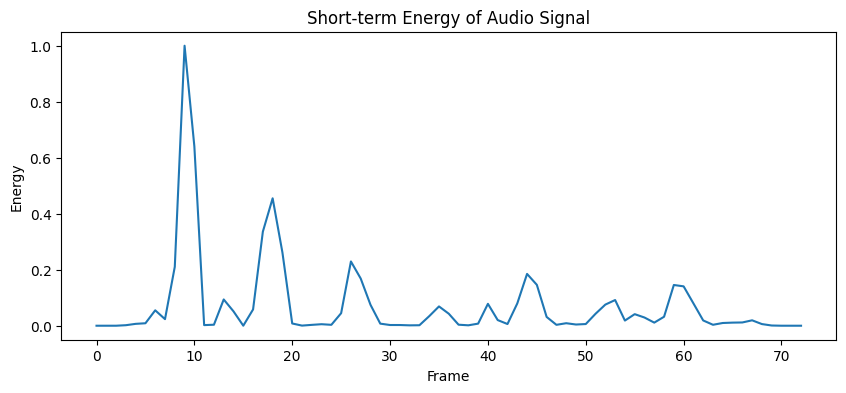

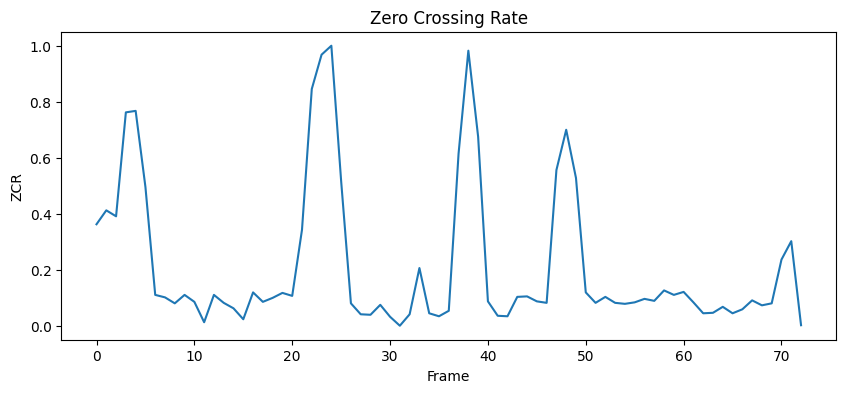

In [31]:
# Load the audio file
# y, sample_rate = librosa.load(audio_path_global)
# Segment audio file
voiced_segments, unvoiced_segments, energy, zcr= segment_audio(samples_global)

# Plot the Energy and Zero Crossing Rate
plot(energy,'Short-term Energy of Audio Signal','Energy')
plot(zcr,'Zero Crossing Rate','ZCR')

# Play separated segments
play(voiced_segments, sample_rate)


In [32]:
play(unvoiced_segments,sample_rate)

## Allosaurus

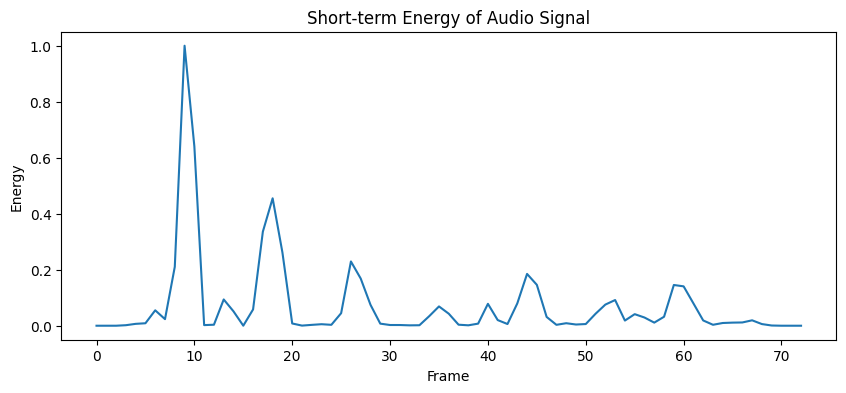

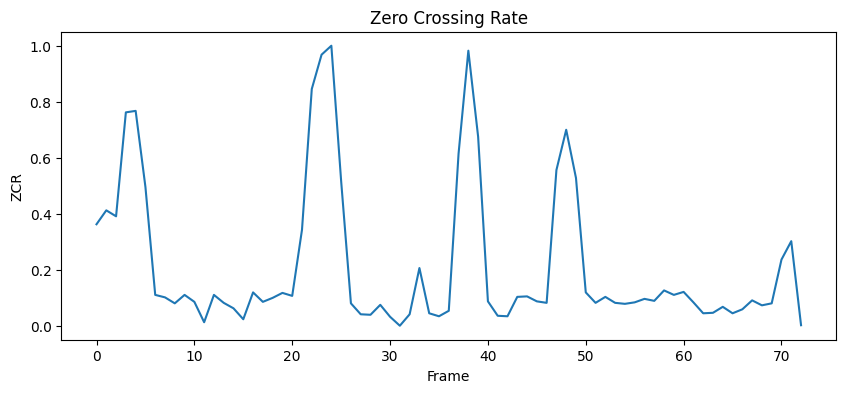

Voiced segments:
Time block =  [0.3, 0.5]  Detected phones= ['i', 'h', 'æ', 'd']
Time block =  [0.6, 0.9]  Detected phones= ['j', 'u', 'd', 'ɑ', 'ɹ']
Time block =  [1.2, 1.3]  Detected phones= ['u']
Time block =  [1.6, 1.7]  Detected phones= ['ɹ', 'i']
Time block =  [1.9, 2.2]  Detected phones= ['i', 'w', 'ɑ', 's', 't']
Time block =  [2.4, 2.5]  Detected phones= ['ɔ', 'tʰ']
Time block =  [2.6, 2.6]  Detected phones= ['ɔ']
Time block =  [2.7, 2.9]  Detected phones= ['l', 'j']
Unvoiced segments:
Time block =  [0.5, 0.6]  Detected phones= ['d', 'j', 'u']
Time block =  [0.7, 0.7]  Detected phones= []
Time block =  [0.9, 1.2]  Detected phones= ['ɹ', 'k', 's', 'u']
Time block =  [1.3, 1.6]  Detected phones= ['ɪ', 'n', 'd', 'k', 'ɹ', 'i']
Time block =  [1.7, 1.9]  Detected phones= ['s', 'i']
Time block =  [2.0, 2.0]  Detected phones= ['w', 'ɑ']
Time block =  [2.2, 2.4]  Detected phones= ['s', 't', 'w', 'ɔ']
Time block =  [2.5, 2.7]  Detected phones= ['tʰ', 'ɔ']
Time block =  [2.9, 3.4]  Detec

In [129]:
from allosaurus.app import read_recognizer

def segment_audio(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path)
   
    # Compute short-term energy
    energy = np.array([sum(abs(y[i:i+1024])**2) for i in range(0, len(y), 1024)])
    


    # Compute zero-crossing rate
    zcr = np.array([sum(librosa.zero_crossings(y[i:i+1024], pad=False)) for i in range(0, len(y), 1024)])

    # Normalize energy and ZCR for thresholding
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    zcr = (zcr - np.min(zcr)) / (np.max(zcr) - np.min(zcr))
    
    plot(energy,'Short-term Energy of Audio Signal','Energy')
    plot(zcr,'Zero Crossing Rate','ZCR')
    # Define thresholds for voiced/unvoiced decision
    energy_threshold = 0.02
    zcr_threshold = 0.4



    # Segment the audio
    voiced_segments = []
    unvoiced_segments = []
    voiced_i = [[0]]
    unvoiced_i = [[0]]
    for i in range(len(energy)):
        start = i * 1024
        end = start + 1024
        startt = round(start/sr*1.0,1)
        endt = round(end/sr*1.0,1)

        if energy[i] > energy_threshold and zcr[i] < zcr_threshold:

            
            
            if voiced_i[-1][-1] == startt:
                voiced_i[-1][-1] = endt
            else:
                voiced_i.append([startt,endt])

            voiced_segments.append(y[start:end])
        else:
            if unvoiced_i[-1][-1] == startt:
                unvoiced_i[-1][-1] = endt
            else:
                unvoiced_i.append([startt,endt])
            unvoiced_segments.append(y[start:end])

    # Return segmented audio
    return voiced_i,unvoiced_i,voiced_segments, unvoiced_segments





# Sample rate of your original audio file (e.g., 44100 Hz)
sample_rate = 22050  # Adjust this to the sample rate of your audio

#segment audio file
index_voiced,index_unvoiced,voiced_segments, unvoiced_segments = segment_audio(audio_path_global)

del index_voiced[0]
del index_unvoiced[0]

index_voiced = [[x,[]] for x in index_voiced]
index_unvoiced = [[x,[]] for x in index_unvoiced]

# load allosaurus model
model = read_recognizer()

# run inference
res = model.recognize(audio_path_global,'eng',timestamp=True)
allo = [x.split(' ') for x in res.splitlines()]
allo =  [[round(float(s),1),x] for s,e,x in allo]

for point,c in allo:
    for i in range(len(index_voiced)):
        start = index_voiced[i][0][0]
        end = index_voiced[i][0][1]
        if point <= end and point >= start:
            index_voiced[i][1].append(c)

    for i in range(len(index_unvoiced)):
        start = index_unvoiced[i][0][0]
        end = index_unvoiced[i][0][1]
        if point <= end and point >= start:
            index_unvoiced[i][1].append(c) 

print("Voiced segments:")

for t,c in index_voiced:
    print('Time block = ',t, ' Detected phones=',c)

print("Unvoiced segments:")

for t,c in index_unvoiced:
    print('Time block = ',t, ' Detected phones=',c)

# Segmentation Techniques

In [33]:
# Instantiate a Segmentation instance to start using SpeechSlice functions 
speechSlice = Segmentation()

<>:8: SyntaxWarning:

invalid escape sequence '\S'

<>:8: SyntaxWarning:

invalid escape sequence '\S'

C:\Users\tabba\AppData\Local\Temp\ipykernel_604\442185679.py:8: SyntaxWarning:

invalid escape sequence '\S'



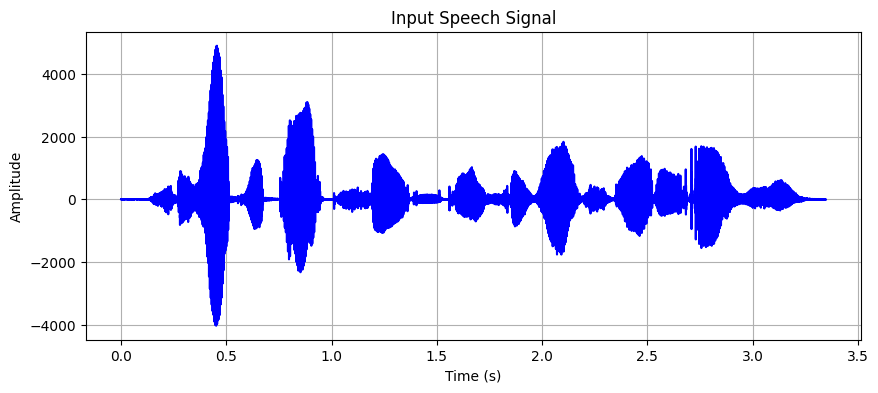

In [34]:
# running tests on input signal 1

# plot and play input signal 1 
sample_rate, audio_data = wavfile.read(audio_path_global)
sd.play(audio_data, sample_rate)
sd.wait()

audio_data, sample_rate = speechSlice.input_and_plot("demo_audio\SA1.WAV.wav", True) 


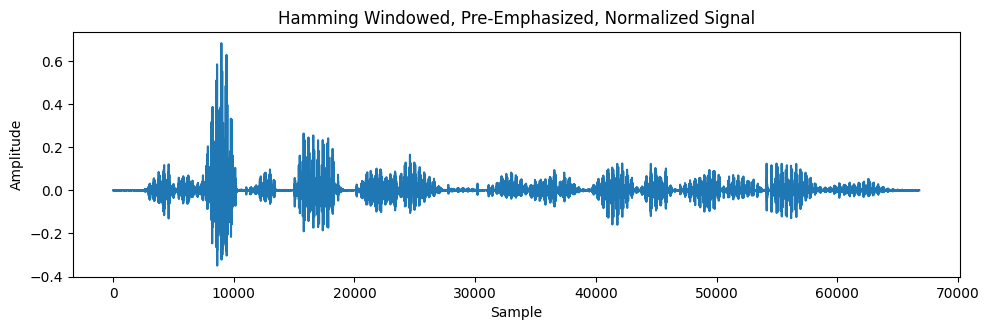

In [35]:
# short time window segmentation, normalize, and pre-emphasize
hamming_short_windows, hamming_signal = speechSlice.split_window_preemphasize(audio_data, sample_rate, 25, 5, plot=True)


## Peakiness Segmentation

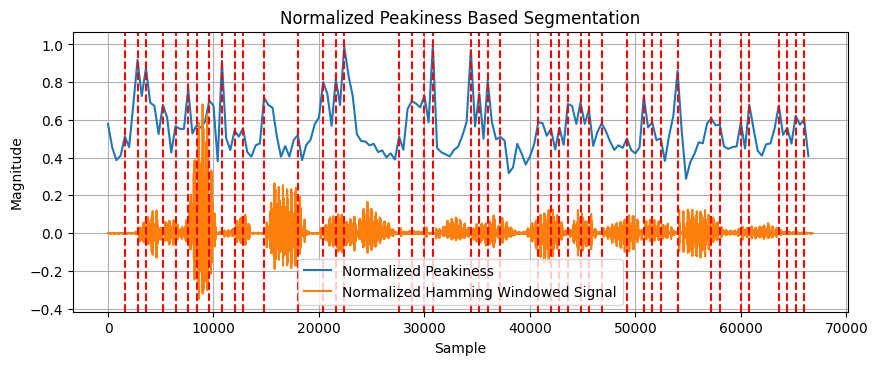

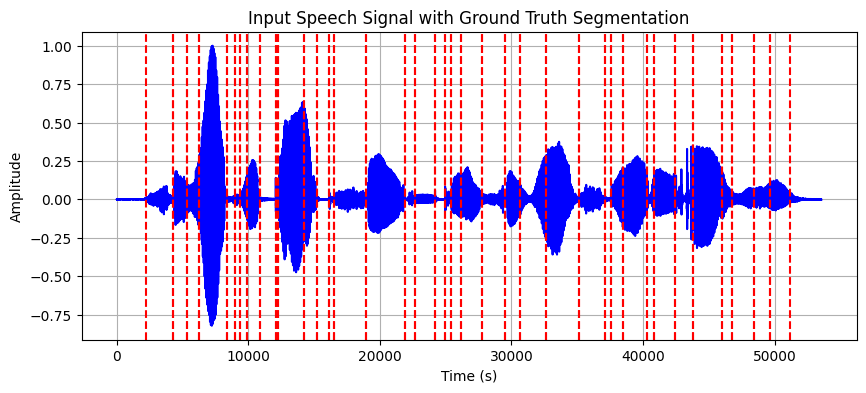

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [36]:
# run peakiness segmentation 
peakiness_segmentation_boundaries = speechSlice.peakiness_segmentation(hamming_short_windows, peakiness_threshold=0.5)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Formant Segmentation

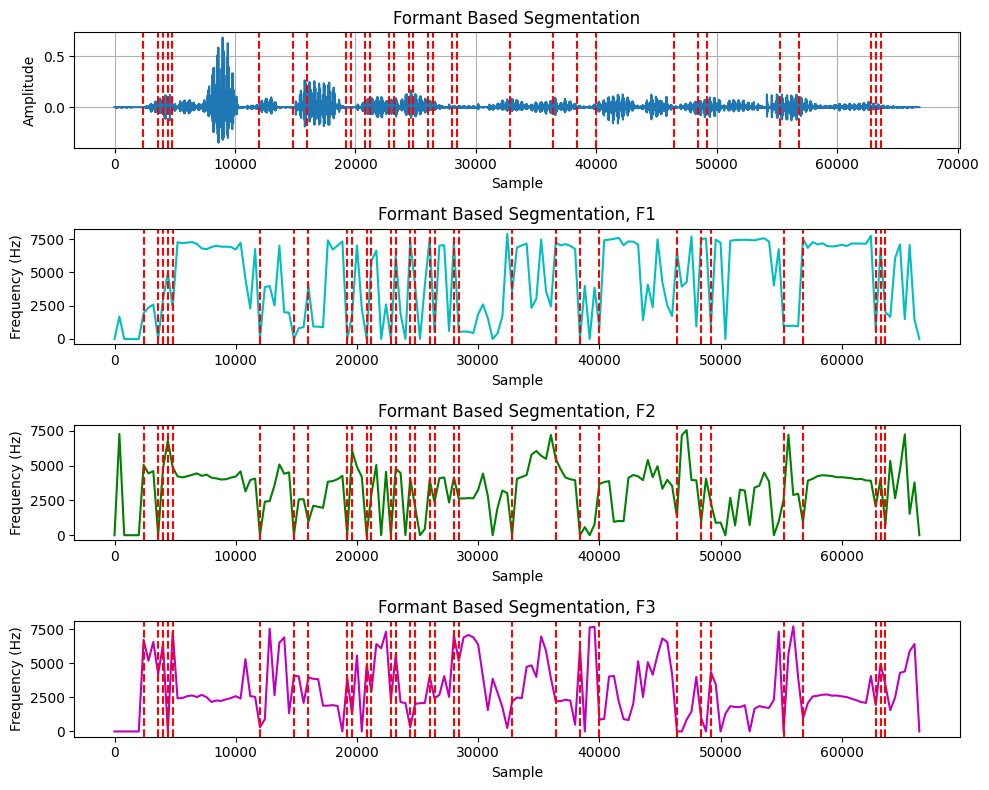

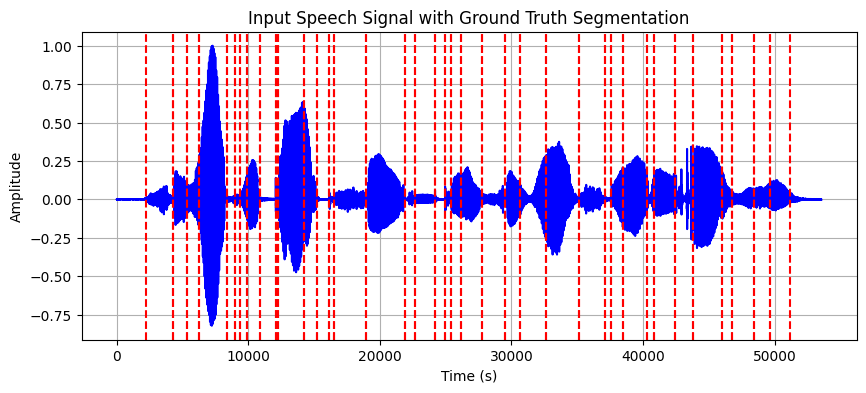

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [37]:
# run formant segmentation
formant_segmentation_boundaries, formants_at_boundaries = speechSlice.formant_segmentation(hamming_short_windows, sample_rate)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Teager Energy Segmentation

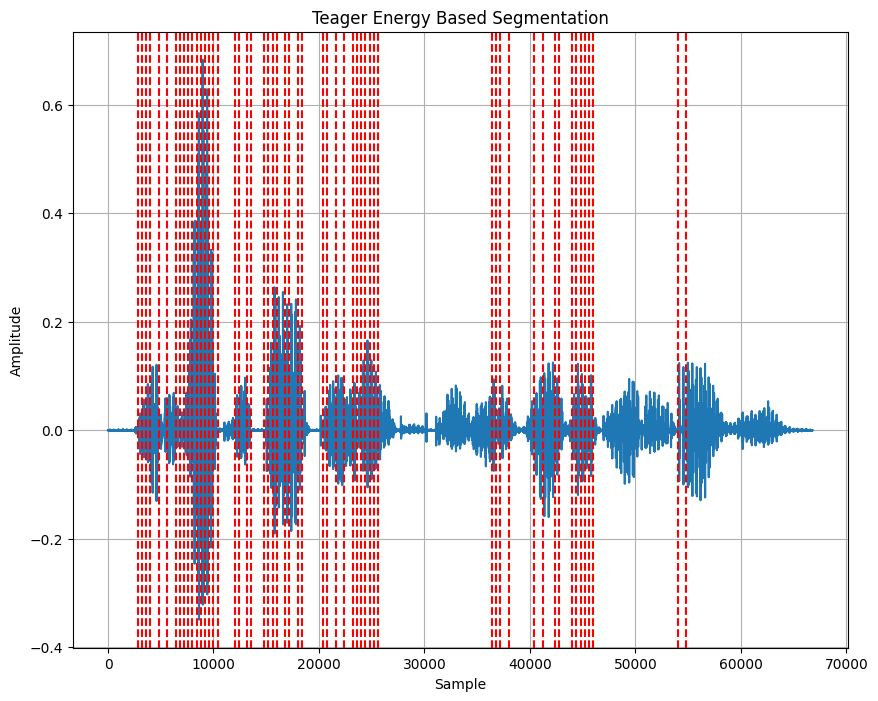

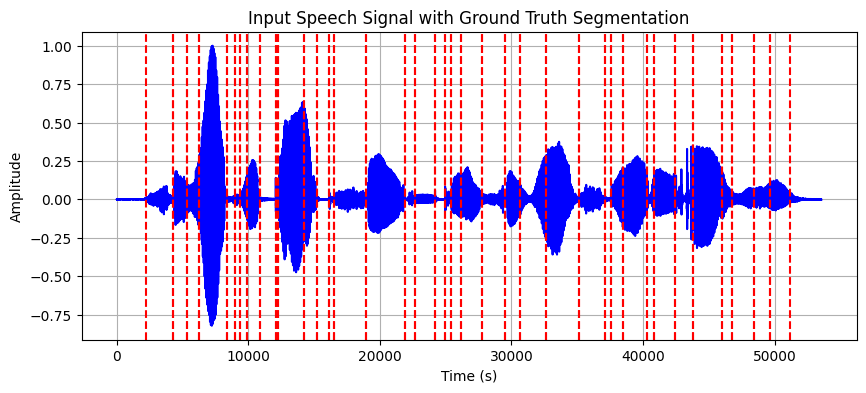

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [38]:
# teager energy based segmentation 
teager_segmentation_boundaries = speechSlice.teager_energy_segmentation(hamming_short_windows, energy_threshold=0.009)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Matusita Distance Segmentation

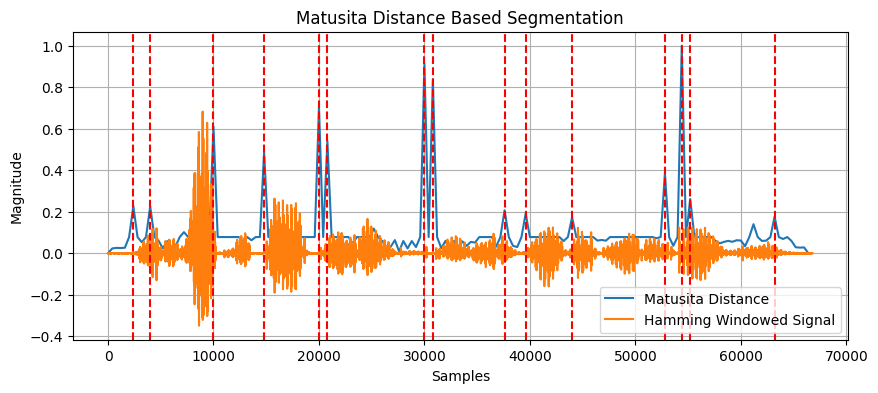

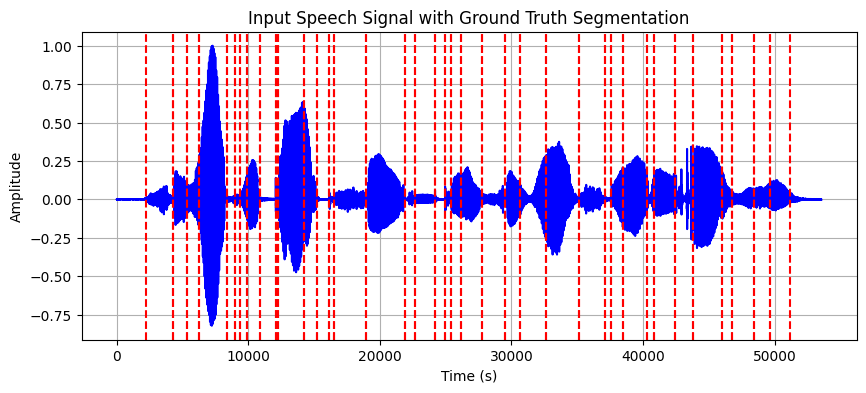

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [39]:
# Matusita distance based segmentation 
matusita_segmentation_boundaries = speechSlice.matusita_dist_segmentation(hamming_short_windows, matusita_threshold=0.15)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

## Fitting Process Segmentation

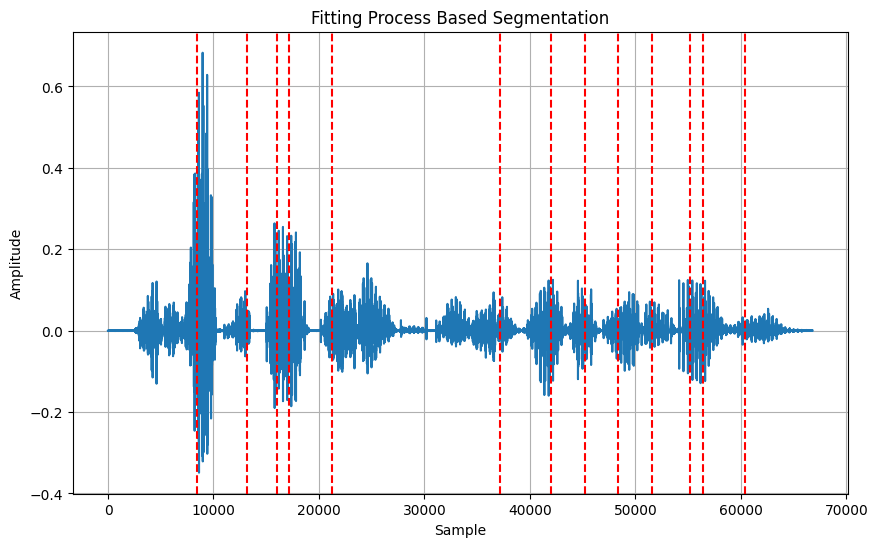

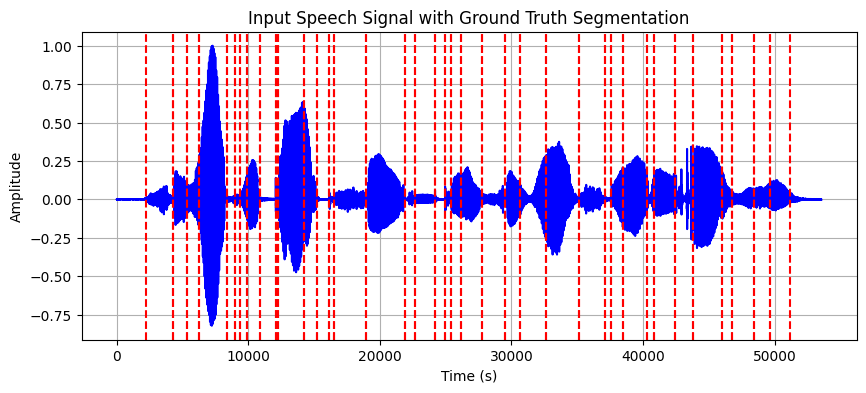

(array([ 0.00020412,  0.00081649,  0.00020412, ...,  0.00061237,
         0.00102062, -0.00224536]),
 16000)

In [40]:
# Fitting process segmentation 
fitting_proc_boundaries = speechSlice.fitting_proc_segmentation(hamming_short_windows, a=1, b=0.01, c=4)
normalize_and_plot(audio_path_global, "demo_audio/SA1.PHN")

# Vector Embeddings, PCAs, and DBScan Models

In [89]:
##################################################
#     Importing Python file and Libraries        #
##################################################

from vector_embeddings import Vector_Embeddings
vect_embed = Vector_Embeddings()

from sklearn.decomposition import PCA

In [90]:
##################################################
#       Declaring visualization functions        #
##################################################

def visualize_3d(X_3d, fig_title, colors=None):
    df = pd.DataFrame(
            {
                "Feature 1": X_3d[:, 0],
                "Feature 2": X_3d[:, 1],
                "Feature 3": X_3d[:, 2],
            }
        )
    fig = px.scatter_3d(
            df,
            x="Feature 1",
            y="Feature 2",
            z="Feature 3",
            title=fig_title,
            color=colors,
            width=960,
            height=700,
        )
    fig.update_traces(
            marker=dict(size=5), selector=dict(mode="markers")
        )  # Customize if needed
    fig.show()


def visualize_2d(X_2d, fig_title, colors=None):
    df = pd.DataFrame(
            {"Feature 1": X_2d[:, 0], "Feature 2": X_2d[:, 1]}
        )
    fig = px.scatter(
        df, x="Feature 1", y="Feature 2", color=colors, title=fig_title
    )
    fig.show()

## MFCC then DTW Model on 'Rhyme_Words.wav'

### MFCC then DTW

In [77]:
audio_path = 'Rhyme_Words.wav'
# Load the audio file
y, sample_rate = librosa.load(audio_path)
dtw_matrix = vect_embed.mfcc_dtw_embed(y, sample_rate)

num_words = len(dtw_matrix)

colors = ['blue']*((int)(num_words*0.23)) + ['red']*((int)(num_words*0.19)) + ['purple']*((int)(num_words*0.19)) + ['green']*((int)(num_words*0.15)) + ['orange']*((int)(num_words*0.23))
# Addressing rounding issues
colors = colors + ['orange']*(num_words - len(colors))
print("Shape of dtw_matrix is ", np.shape(dtw_matrix))

Shape of dtw_matrix is  (1026, 651)


### PCA

In [119]:
dtw_matrix = np.array(dtw_matrix)
dim_red_dtw = PCA(n_components=3)
dim_red_dtw.fit(dtw_matrix)
print("The explained variance by each PCA component  is ", dim_red_dtw.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red_dtw.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red_dtw.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red_dtw.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_dtw.components_[0][first_components_idxs[0]], " of component ", first_components_idxs[0])
print(dim_red_dtw.components_[0][first_components_idxs[1]], " of component ", first_components_idxs[1])
print(dim_red_dtw.components_[0][first_components_idxs[2]], " of component ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_dtw.components_[1][second_components_idxs[0]], " of component ", second_components_idxs[0])
print(dim_red_dtw.components_[1][second_components_idxs[1]], " of component ", second_components_idxs[1])
print(dim_red_dtw.components_[1][second_components_idxs[2]], " of component ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_dtw.components_[2][third_components_idxs[0]], " of component ", third_components_idxs[0])
print(dim_red_dtw.components_[2][third_components_idxs[1]], " of component ", third_components_idxs[1])
print(dim_red_dtw.components_[2][third_components_idxs[2]], " of component ", third_components_idxs[2])

# Without colors labeling the ground-truth different word groups
threeD_vectors_dtw = dim_red_dtw.transform(dtw_matrix)
visualize_3d(threeD_vectors_dtw, "DTW Word Vectors Only 3 Dimensions")
twoD_vectors_dtw = threeD_vectors_dtw[:, 0:2]
visualize_2d(twoD_vectors_dtw, "DTW Word Vectors Only 2 Dimensions")

# With colors labeling the ground-truth different word groups
visualize_3d(threeD_vectors_dtw, "DTW Word Vectors Only 3 Dimensions", colors)
visualize_2d(twoD_vectors_dtw, "DTW Word Vectors Only 2 Dimensions", colors)

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.85488195 0.08067125 0.02276561]
The 1st PCA component expressed as a linear combination of the original features (columns): 
0.06074948097809227  of component  468
0.0603777393890774  of component  278
0.06036480448841971  of component  52
The 2nd PCA component expressed as a linear combination of the original features (columns): 
0.07896956040600206  of component  168
0.0769679677167776  of component  149
0.07625062477553649  of component  472
The 3rd PCA component expressed as a linear combination of the original features (columns): 
0.13358987815726922  of component  527
0.12580796715594872  of component  308
0.12494682688379563  of component  433


### DBScan

In [120]:
db_model_threeD_dtw = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_dtw)
db_colors_threeD_dtw = db_model_threeD_dtw.labels_
visualize_3d(threeD_vectors_dtw, "DBScan on 3D DTW Vectors", db_colors_threeD_dtw)

db_model_twoD_dtw = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_dtw)
db_colors_twoD_dtw = db_model_twoD_dtw.labels_
visualize_2d(twoD_vectors_dtw, "DBScan on 2D DTW Vectors", db_colors_twoD_dtw)

## MFCC on 'Rhyme_Words.wav'

### MFCC

In [93]:
mfcc_matrix = vect_embed.mfcc_embed(y, sample_rate)
print("Shape of mfcc_matrix is ", np.shape(mfcc_matrix))

Shape of mfcc_matrix is  (1026, 39)


### PCA

In [121]:
mfcc_matrix = np.array(mfcc_matrix)
dim_red_mfcc = PCA(n_components=3)
dim_red_mfcc.fit(mfcc_matrix)
print("The explained variance by each PCA component  is ", dim_red_mfcc.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red_mfcc.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red_mfcc.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red_mfcc.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_mfcc.components_[0][first_components_idxs[0]], " of MFCC coefficient ", first_components_idxs[0])
print(dim_red_mfcc.components_[0][first_components_idxs[1]], " of MFCC coefficient ", first_components_idxs[1])
print(dim_red_mfcc.components_[0][first_components_idxs[2]], " of MFCC coefficient ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_mfcc.components_[1][second_components_idxs[0]], " of MFCC coefficient ", second_components_idxs[0])
print(dim_red_mfcc.components_[1][second_components_idxs[1]], " of MFCC coefficient ", second_components_idxs[1])
print(dim_red_mfcc.components_[1][second_components_idxs[2]], " of MFCC coefficient ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_mfcc.components_[2][third_components_idxs[0]], " of MFCC coefficient ", third_components_idxs[0])
print(dim_red_mfcc.components_[2][third_components_idxs[1]], " of MFCC coefficient ", third_components_idxs[1])
print(dim_red_mfcc.components_[2][third_components_idxs[2]], " of MFCC coefficient ", third_components_idxs[2])

# Without colors labeling the ground-truth different word groups
threeD_vectors_mfcc = dim_red_mfcc.transform(mfcc_matrix)
visualize_3d(threeD_vectors_mfcc, "MFCC Word Vectors Only 3 Dimensions")
twoD_vectors_mfcc = threeD_vectors_mfcc[:, 0:2]
visualize_2d(twoD_vectors_mfcc, "MFCC Word Vectors Only 2 Dimensions")

# With colors labeling the ground-truth different word groups
visualize_3d(threeD_vectors_mfcc, "MFCC Word Vectors Only 3 Dimensions", colors)
visualize_2d(twoD_vectors_mfcc, "MFCC Word Vectors Only 2 Dimensions", colors)

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.60705423 0.16188157 0.04938703]
The 1st PCA component expressed as a linear combination of the original features (columns): 
0.9001981  of MFCC coefficient  0
0.27973768  of MFCC coefficient  1
-0.16993053  of MFCC coefficient  5
The 2nd PCA component expressed as a linear combination of the original features (columns): 
-0.8974474  of MFCC coefficient  1
0.29312867  of MFCC coefficient  0
0.21345396  of MFCC coefficient  3
The 3rd PCA component expressed as a linear combination of the original features (columns): 
-0.70567966  of MFCC coefficient  2
-0.50284684  of MFCC coefficient  3
0.19662566  of MFCC coefficient  10


### DBScan

In [122]:
db_model_threeD_mfcc = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_mfcc)
db_colors_threeD_mfcc = db_model_threeD_mfcc.labels_
visualize_3d(threeD_vectors_mfcc, "DBScan on 3D MFCC Vectors", db_colors_threeD_mfcc)

db_model_twoD_mfcc = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_mfcc)
db_colors_twoD_mfcc = db_model_twoD_mfcc.labels_
visualize_2d(twoD_vectors_mfcc, "DBScan on 2D MFCC Vectors", db_colors_twoD_mfcc)

## MFCC on Peakiness-segmented 'Rhyme_Words.wav'

### MFCC

Shape of mfcc_matrix_peak is  (185, 39)


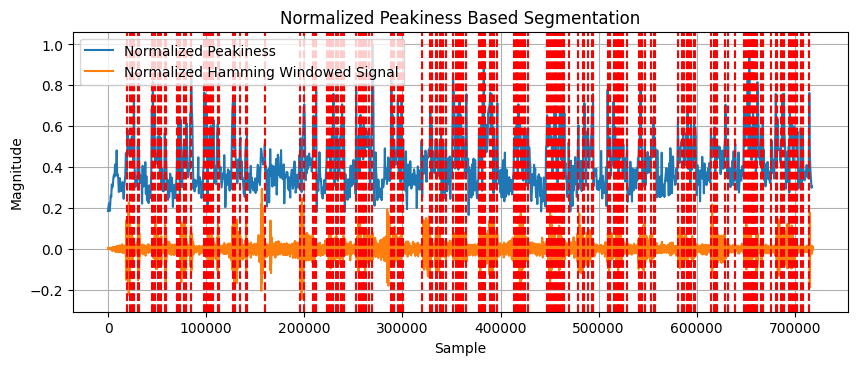

In [123]:
# other_sample_rate, other_data = wavfile.read(audio_path)
other_data, other_sample_rate = librosa.load(audio_path)
# short time window segmentation, normalize, and pre-emphasize
hamming_short_windows, hamming_signal = speechSlice.split_window_preemphasize(other_data, other_sample_rate, 25, 5, plot=False)
last = len(hamming_signal)
# run peakiness segmentation 
peakiness_segmentation_boundaries = speechSlice.peakiness_segmentation(hamming_short_windows, peakiness_threshold=0.5)

# Now, MFCC separately on each segment
N = len(peakiness_segmentation_boundaries) + 1
mfcc_matrix_peak = np.zeros((1, 39))
boundary_num = 0
while boundary_num < N:
    if boundary_num == 139: # Just for debugging
        a = 0
    start_idx = 0
    end_idx = last
    if boundary_num > 0:
        start_idx = peakiness_segmentation_boundaries[boundary_num-1]
    if boundary_num < N-1:
        end_idx = peakiness_segmentation_boundaries[boundary_num]
    # If the word length is too small to be an actual word (border is too close to another border)
    diff = end_idx - start_idx
    if start_idx + 40 > end_idx:
        boundary_num += 1
        continue
    mfcc_row_peak = np.average(vect_embed.mfcc_custom_embed(hamming_signal[start_idx:end_idx], other_sample_rate), axis=0)
    if boundary_num == 0:
        mfcc_matrix_peak[0, :] = mfcc_row_peak
    else:
        mfcc_matrix_peak = np.vstack((mfcc_matrix_peak, mfcc_row_peak))
    boundary_num += 1
print("Shape of mfcc_matrix_peak is ", np.shape(mfcc_matrix_peak))

### PCA

In [124]:
mfcc_matrix_peak = np.array(mfcc_matrix_peak)
dim_red_peak = PCA(n_components=3)
dim_red_peak.fit(mfcc_matrix_peak)
print("The explained variance by each PCA component  is ", dim_red_peak.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red_peak.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red_peak.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red_peak.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_peak.components_[0][first_components_idxs[0]], " of MFCC coefficient ", first_components_idxs[0])
print(dim_red_peak.components_[0][first_components_idxs[1]], " of MFCC coefficient ", first_components_idxs[1])
print(dim_red_peak.components_[0][first_components_idxs[2]], " of MFCC coefficient ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_peak.components_[1][second_components_idxs[0]], " of MFCC coefficient ", second_components_idxs[0])
print(dim_red_peak.components_[1][second_components_idxs[1]], " of MFCC coefficient ", second_components_idxs[1])
print(dim_red_peak.components_[1][second_components_idxs[2]], " of MFCC coefficient ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_peak.components_[2][third_components_idxs[0]], " of MFCC coefficient ", third_components_idxs[0])
print(dim_red_peak.components_[2][third_components_idxs[1]], " of MFCC coefficient ", third_components_idxs[1])
print(dim_red_peak.components_[2][third_components_idxs[2]], " of MFCC coefficient ", third_components_idxs[2])


num_words_peak = len(mfcc_matrix_peak)

colors_peak = ['blue']*((int)(num_words_peak*0.23)) + ['red']*((int)(num_words_peak*0.19)) + ['purple']*((int)(num_words_peak*0.19)) + ['green']*((int)(num_words_peak*0.15)) + ['orange']*((int)(num_words_peak*0.23))
# Addressing rounding issues
colors_peak = colors_peak + ['orange']*(num_words_peak - len(colors_peak))

# Without colors labeling the ground-truth different word groups
threeD_vectors_mfcc_peak = dim_red_peak.transform(mfcc_matrix_peak)
visualize_3d(threeD_vectors_mfcc_peak, "MFCC Word Vectors Only 3 Dimensions")
twoD_vectors_mfcc_peak = threeD_vectors_mfcc_peak[:, 0:2]
visualize_2d(twoD_vectors_mfcc_peak, "MFCC Word Vectors Only 2 Dimensions")

# With colors labeling the ground-truth different word groups
visualize_3d(threeD_vectors_mfcc_peak, "MFCC Word Vectors Only 3 Dimensions", colors_peak)
visualize_2d(twoD_vectors_mfcc_peak, "MFCC Word Vectors Only 2 Dimensions", colors_peak)

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.60560392 0.19722031 0.04474993]
The 1st PCA component expressed as a linear combination of the original features (columns): 
0.9897712923789902  of MFCC coefficient  0
-0.1097069463552332  of MFCC coefficient  2
-0.04745782909780944  of MFCC coefficient  5
The 2nd PCA component expressed as a linear combination of the original features (columns): 
-0.9351216435275824  of MFCC coefficient  1
0.1708789530733006  of MFCC coefficient  5
0.13106062526635673  of MFCC coefficient  7
The 3rd PCA component expressed as a linear combination of the original features (columns): 
-0.6756709467392473  of MFCC coefficient  2
-0.4115663091036151  of MFCC coefficient  5
-0.2970646350940165  of MFCC coefficient  6


### DBScan

In [125]:
db_model_threeD_mfcc_peak = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_mfcc_peak)
db_colors_threeD_mfcc_peak = db_model_threeD_mfcc_peak.labels_
visualize_3d(threeD_vectors_mfcc_peak, "DBScan on 3D MFCC Vectors", db_colors_threeD_mfcc_peak)

db_model_twoD_mfcc_peak = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_mfcc_peak)
db_colors_twoD_mfcc_peak = db_model_twoD_mfcc_peak.labels_
visualize_2d(twoD_vectors_mfcc_peak, "DBScan on 2D MFCC Vectors", db_colors_twoD_mfcc_peak)